# Supervised Learning
This file demonstrates five supervised learning algorithms' performance on the classfication problem on text data. The five supervised learning algorithms are:


*   Decision Tree
*   Neural Network
*   Boosting
*   SVM
*   KNN

## Data Preprocessing




In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 

#for text pre-processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package punkt to /Users/wind/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wind/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/wind/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/wind/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/wind/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The text dataset (depression_dataset_reddit_cleaned) is adopted from kaggle (https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned), which contains texts to classify mental health.

### Load Data

In [2]:
url_1 = "https://github.com/charles2648/CS7641_Supervised_Learning/blob/main/depression_dataset_reddit_cleaned.csv?raw=true"
# load depression data
df_depression = pd.read_csv(url_1)
print("Data has",len(df_depression),"rows and", len(df_depression.columns),"columns.")
if df_depression.isnull().values.any():
    print("Warning: Missing Data")
df_depression.head()

Data has 7731 rows and 2 columns.


,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


### Explore the data 



#### EDA
Check the distribution of class type

0    3900
1    3831
Name: is_depression, dtype: int64


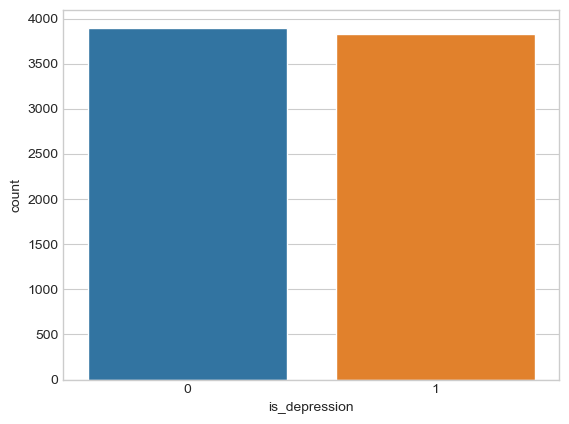

In [3]:
print(df_depression['is_depression'].value_counts())
_ = sns.countplot(x='is_depression', data=df_depression)

We can see that the data is balanced. 

#### Text processing

Lemmatization is used to remove inflectional endings

Parts of codes are modified based on [this page](https://github.com/vijayaiitk/NLP-text-classification-model/blob/main/NLP%20text%20classification%20model%20Github.ipynb)

The dataset is cleaned before imported. Some steps like lowercase text, stripping the whitespace are ignored. Full steps can be referred to the original code. 

In [4]:
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    text = re.sub(r'[^a-zA-Z]',' ',text) # removes unalfabetic signs
  
    return text


#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#2. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [5]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_depression['processed_text'] = df_depression['clean_text'].apply(lambda x: finalpreprocess(x))
df_depression.drop(['clean_text'], axis=1)

,is_depression,processed_text
0,1,understand people reply immediately op invitat...
1,1,welcome r depression check post place take mom...
2,1,anyone else instead sleep depressed stay night...
3,1,kind stuffed around lot life delay inevitable ...
4,1,sleep great comfort escape whenever wake day l...
...,...,...
7726,0,snow
7727,0,moulin rouge mad cry
7728,0,try shout find people list
7729,0,ughh find red sox hat get ta wear creepy nick ...


## Supervised Learning

In this part, five supervised learning models (Decision Tree, Neural Network, Boosting, SVM, KNN) are used to classify whether has depression. TF-IDF (term frequency–inverse document frequency) is used to convert text data to numerical data. Parameters are tuned to show how different parameters affect the performance of the models.  

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
X_train, X_test, y_train, y_test = train_test_split(np.array(df_depression["processed_text"]),
                                                  np.array(df_depression["is_depression"]),
                                                  test_size=0.2,
                                                  shuffle=True, random_state=100)

#TF-IDF
# Convert x_train to vector 
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_tfidf = tfidf_vectorizer.transform(X_test) 

### Define Helper functions
Let's define some helper functions that will be used across all of the models. We define a function that plots the learning curve of an classification model. Additionally, we define functions to output final model scores using an untouched test dataset.

In [7]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import itertools
import timeit

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['font.size'] = 12

def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = [] #model performance score (f1)
    cv_mean = []  #model performance score (f1)
    fit_mean = [] #model fit/training time
    pred_mean = [] #model test/prediction times
    train_sizes = (np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True, error_score='raise')
        
        train_mean.append(np.mean(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time']))
    
    train_mean = np.array(train_mean)
    cv_mean = np.array(cv_mean)
    fit_mean = np.array(fit_mean)
    
    plot_LC(train_sizes, train_mean, cv_mean, title)
    plot_times(train_sizes, fit_mean, pred_mean, title)
    
    return train_sizes, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, cv_mean, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, pred_mean, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_mean, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print("Model Evaluation Metrics Using Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='tab20c', display_labels=clf.classes_)
    disp.plot()

### Neural Network



In [8]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    hlist = np.linspace(1,20,10).astype('int')
    for i in hlist:         
            clf = MLPClassifier(hidden_layer_sizes=(i,), solver='adam', activation='relu',
                                learning_rate_init=0.05, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neurons')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = np.linspace(1,20,5).astype('int')
    learning_rates = [0.01, 0.05, .1]
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates}
    # 10-fold cross validation
    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='relu',random_state=100),
                       param_grid=param_grid, cv=10, scoring="accuracy")
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init']

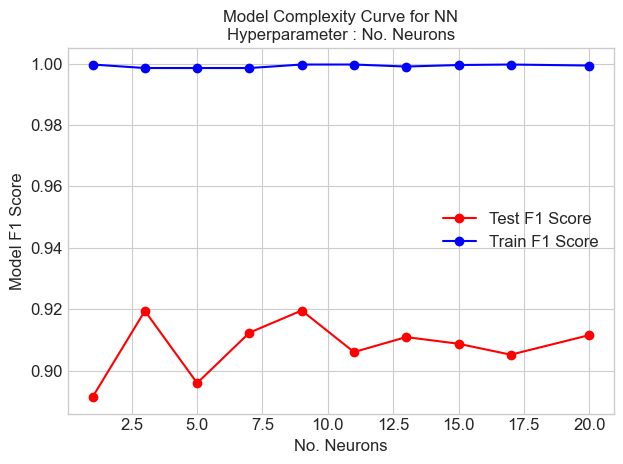

Per Hyperparameter tuning, best parameters are:
{'hidden_layer_sizes': 20, 'learning_rate_init': 0.05}


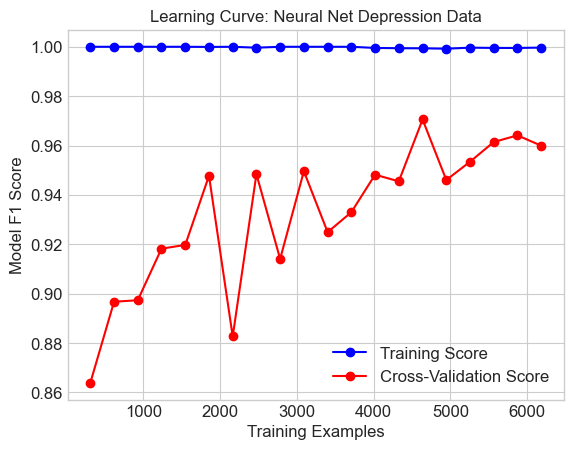

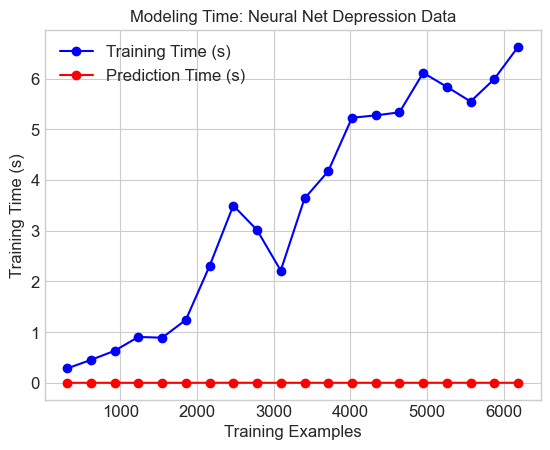

Model Evaluation Metrics Using Test Dataset
*****************************************************
Model Training Time (s):   4.21891
Model Prediction Time (s): 0.00060

F1 Score:  0.91
Accuracy:  0.91     AUC:       0.91
Precision: 0.89     Recall:    0.93
*****************************************************


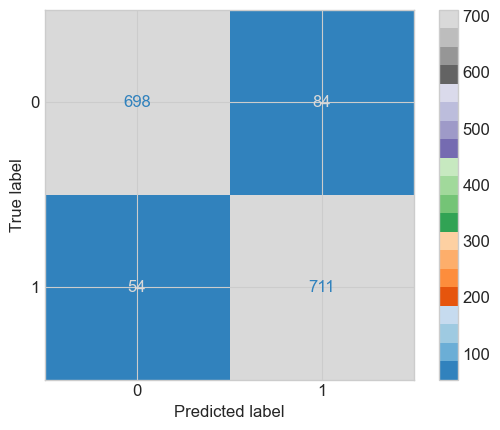

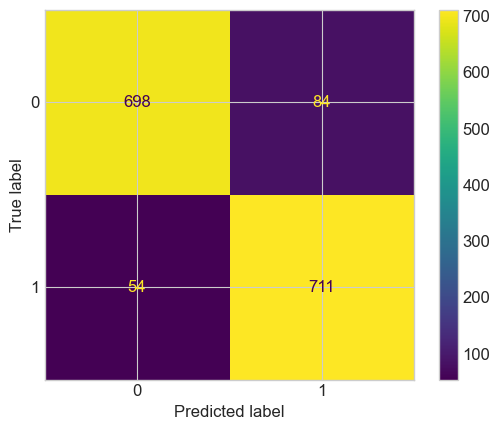

In [9]:
# NN
hyperNN(X_train_tfidf, y_train, X_test_tfidf, y_test,title="Model Complexity Curve for NN\nHyperparameter : No. Neurons")
h_units, learn_rate = NNGridSearchCV(X_train_tfidf, y_train)
estimator = MLPClassifier(hidden_layer_sizes=(h_units,), solver='adam', activation='relu',
                               learning_rate_init=learn_rate, random_state=100)
_, NN_fit_time, NN_pred_time = plot_learning_curve(estimator, X_train_tfidf, y_train, title="Neural Net Depression Data")
final_classifier_evaluation(estimator, X_train_tfidf, X_test_tfidf, y_train, y_test)

The final section for neural network will plot the loss curve.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


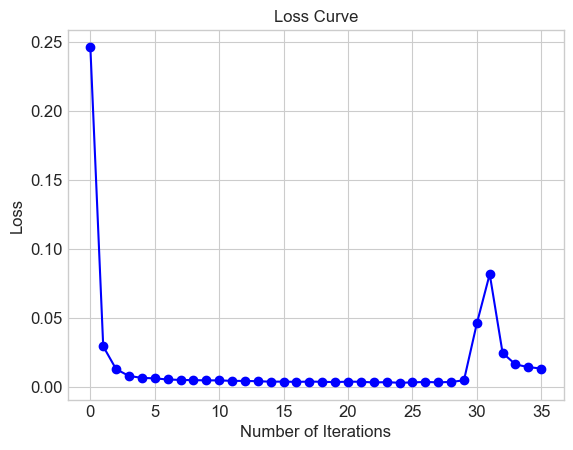

In [10]:
estimator= MLPClassifier(hidden_layer_sizes=(20,), solver='adam', activation='relu',
                               learning_rate_init=0.05, random_state=100, max_iter=500)

estimator.fit(X_train_tfidf, y_train)
a = estimator.loss_curve_

plt.figure()
plt.title("Loss Curve")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(a, 'o-', color="b")
plt.legend(loc="best")
plt.show()

### Support Vector Machine

This section will build a support vector machine classifier. The primary hyperparameter will be kernel function: linear, polynomial, rbf (radial basis function), and sigmoid. We will also explore the penalty term 'C' and the kernel coefficient 'gamma'.

In [11]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = SVC(kernel=i, degree=j, random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']
    plt.plot(xvals, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

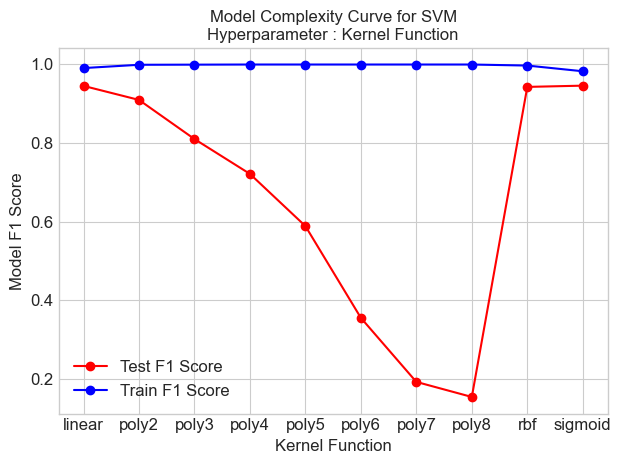

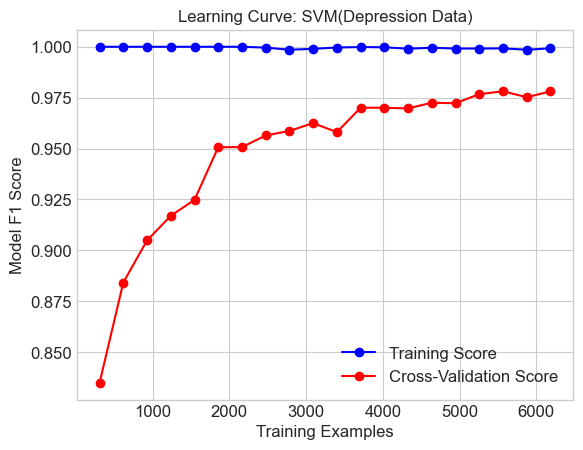

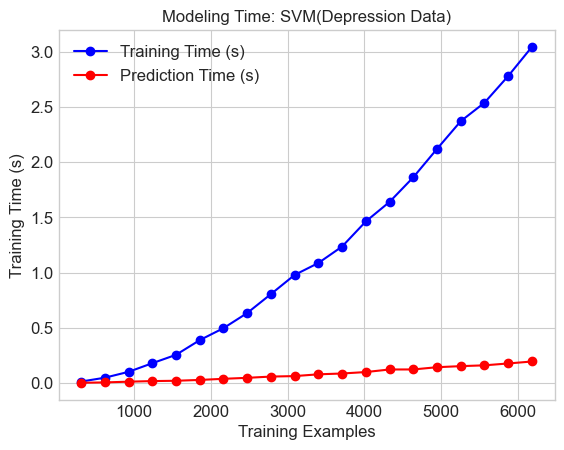

Model Evaluation Metrics Using Test Dataset
*****************************************************
Model Training Time (s):   3.32032
Model Prediction Time (s): 0.50814

F1 Score:  0.94
Accuracy:  0.94     AUC:       0.94
Precision: 0.96     Recall:    0.93
*****************************************************


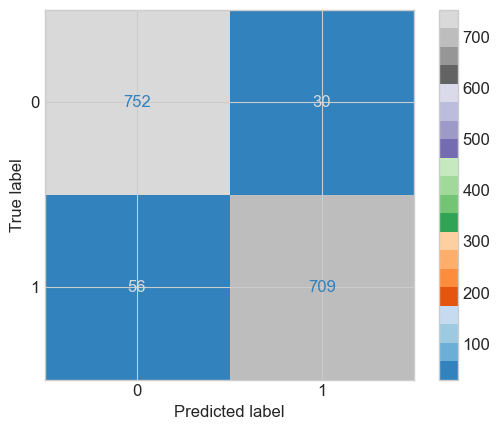

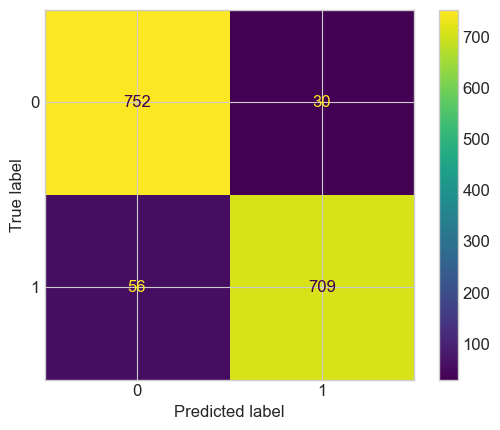

In [12]:
# SVM
hyperSVM(X_train_tfidf, y_train, X_test_tfidf, y_test,title="Model Complexity Curve for SVM\nHyperparameter : Kernel Function")
estimator = SVC(kernel='rbf', random_state=100)
_, SVM_fit_time, SVM_pred_time = plot_learning_curve(estimator, X_train_tfidf, y_train,title="SVM(Depression Data)")
final_classifier_evaluation(estimator, X_train_tfidf, X_test_tfidf, y_train, y_test)

### KNN 

This section will build a classifier using K-nearest neighbors. The hyperparameter will be n_neighbors. The standard euclidean distance for all models is used here. The Model Complexity curve will show F1 score as a function of number of neighbors.

In [13]:
from sklearn.neighbors import KNeighborsClassifier as kNN

def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,31,30).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

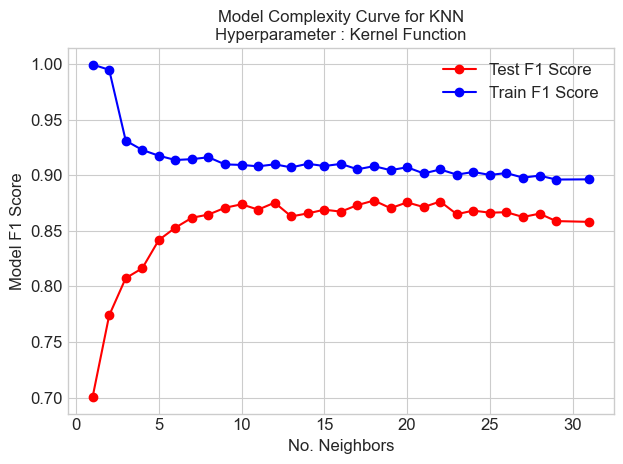

/Users/wind/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


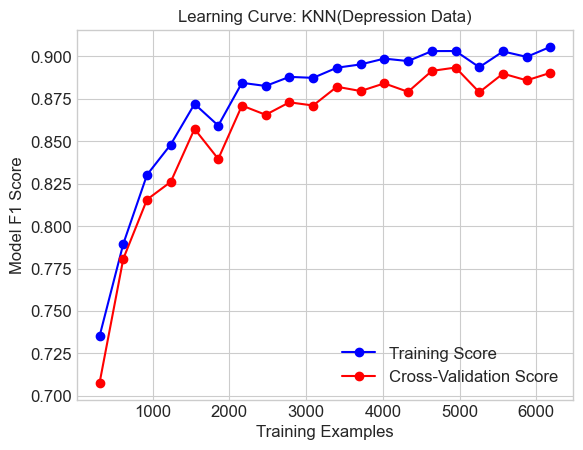

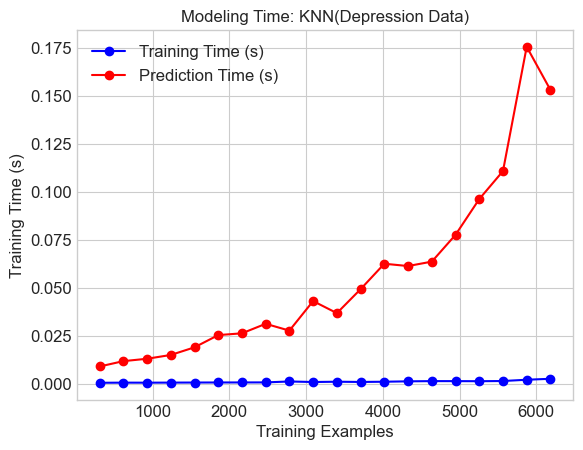

Model Evaluation Metrics Using Test Dataset
*****************************************************
Model Training Time (s):   0.00119
Model Prediction Time (s): 0.15675

F1 Score:  0.88
Accuracy:  0.87     AUC:       0.87
Precision: 0.85     Recall:    0.91
*****************************************************


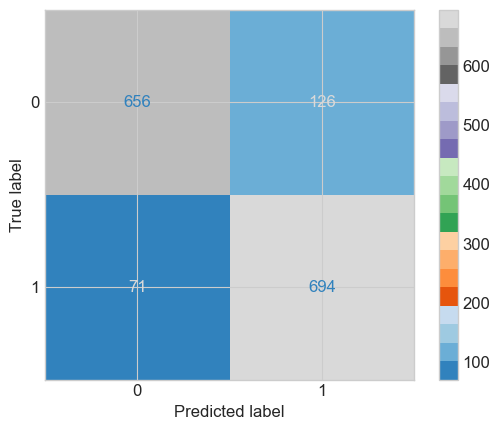

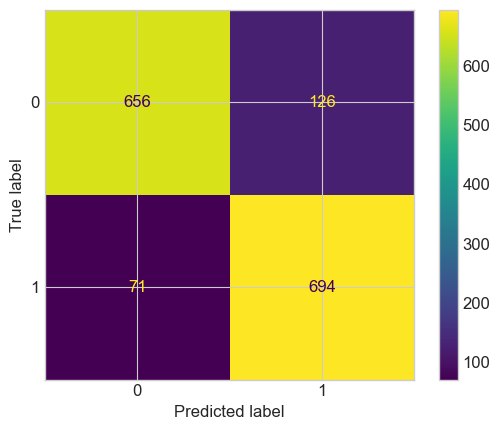

In [14]:
# KNN
hyperKNN(X_train_tfidf, y_train, X_test_tfidf, y_test,title="Model Complexity Curve for KNN\nHyperparameter : Kernel Function")
estimator = kNN(n_neighbors=20, n_jobs=-1)
_, KNN_fit_time, KNN_pred_time = plot_learning_curve(estimator, X_train_tfidf, y_train,title="KNN(Depression Data)")
final_classifier_evaluation(estimator, X_train_tfidf, X_test_tfidf, y_train, y_test)

### Decision Tree

This section will build a Decision Tree Classifier using Gini index to determine the best feature split per the ID3 algorithm. The model will be pruned using cost complexity pruning technique by controlling paramenter ccp_alpha.

In [15]:
from sklearn.tree import DecisionTreeClassifier

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    clfs = []
    clf = DecisionTreeClassifier(random_state=100)
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    for ccp_alpha in path.ccp_alphas:         
            clf = DecisionTreeClassifier(random_state=100, ccp_alpha=ccp_alpha)
            clf.fit(X_train, y_train)
            clfs.append(clf)

    clfs = clfs[:-1]
    ccp_alphas = path.ccp_alphas[:-1]

    y_pred_trains = [clf.predict(X_train) for clf in clfs]
    y_pred_tests = [clf.predict(X_test) for clf in clfs]

    f1_train = [f1_score(y_train, y_pred_train) for y_pred_train in y_pred_trains]
    f1_test = [f1_score(y_test, y_pred_test) for y_pred_test in y_pred_tests]
            
      
    plt.plot(ccp_alphas, f1_test, 'o-', color='r', label='Test F1 Score', drawstyle="steps-post")
    plt.plot(ccp_alphas, f1_train, 'o-', color = 'b', label='Train F1 Score', drawstyle="steps-post")
    plt.ylabel('Model F1 Score')
    plt.xlabel('Complexity Parameter')

    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

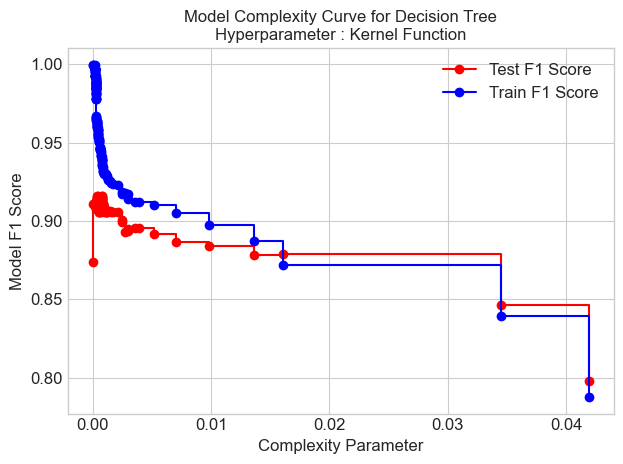

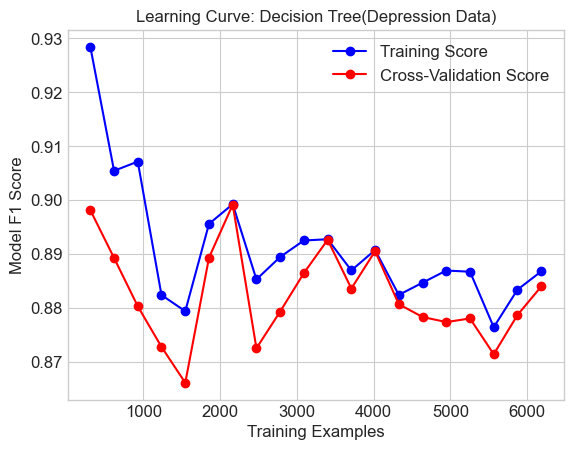

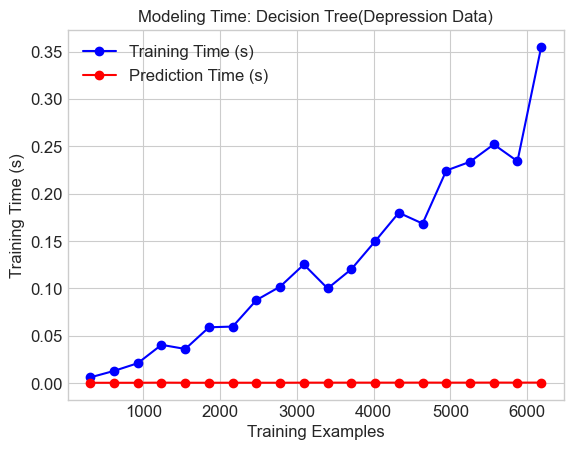

Model Evaluation Metrics Using Test Dataset
*****************************************************
Model Training Time (s):   0.31755
Model Prediction Time (s): 0.00029

F1 Score:  0.88
Accuracy:  0.88     AUC:       0.88
Precision: 0.92     Recall:    0.84
*****************************************************


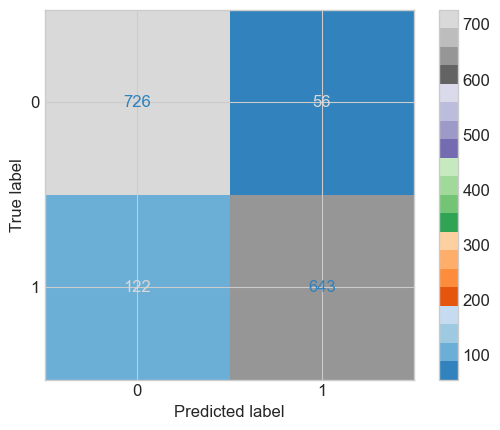

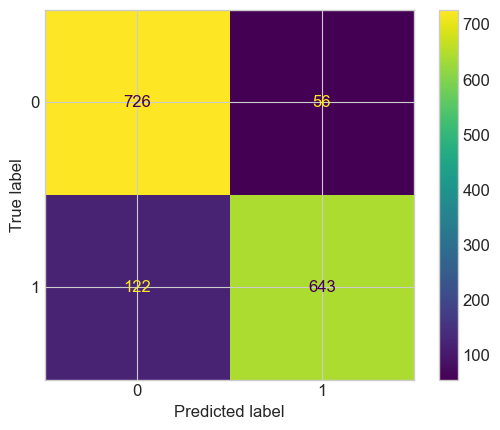

In [16]:
# Setting ccp_alpha=0.015 maximizes the testing accuracy
estimator = DecisionTreeClassifier(random_state=100, ccp_alpha=0.015)
# Decision Tree
hyperTree(X_train_tfidf, y_train, X_test_tfidf, y_test,title="Model Complexity Curve for Decision Tree\nHyperparameter : Kernel Function")
_, DT_fit_time, DT_pred_time = plot_learning_curve(estimator, X_train_tfidf, y_train,title="Decision Tree(Depression Data)")
final_classifier_evaluation(estimator, X_train_tfidf, X_test_tfidf, y_train, y_test)

### Boosted Decision Tree

This section will implement a boosted version of the decision tree. Gradient tree boosting is used. The hyperparameter of n_estimators and learning rate are tuned to determine the contribution of each tree classifier.

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

def hyperBoost(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,100,10).astype('int')
    for i in n_estimators:         
            clf = GradientBoostingClassifier(n_estimators=i, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(n_estimators, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def BoostedGridSearchCV(X_train, y_train):
    #parameters to search:
    #n_estimators, learning_rate
    param_grid = {'n_estimators': np.linspace(10,100,10).round().astype('int'),
                  'learning_rate': np.linspace(.01,1,4)}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['n_estimators'], boost.best_params_['learning_rate']

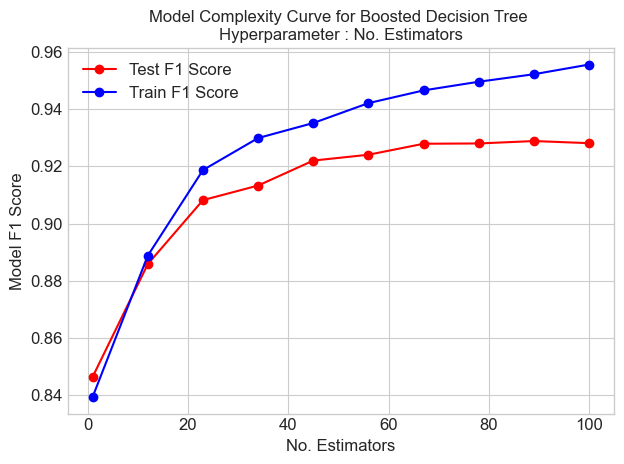

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.34, 'n_estimators': 100}


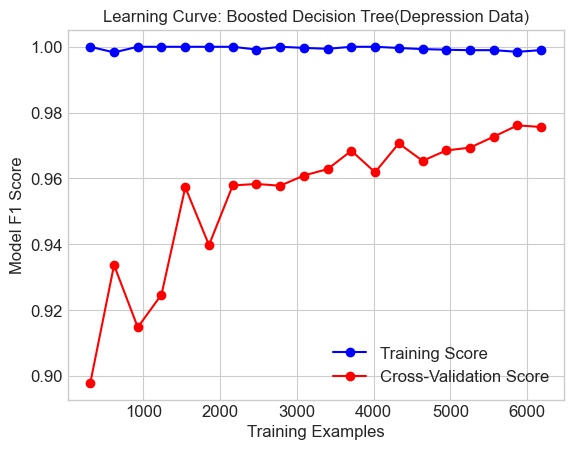

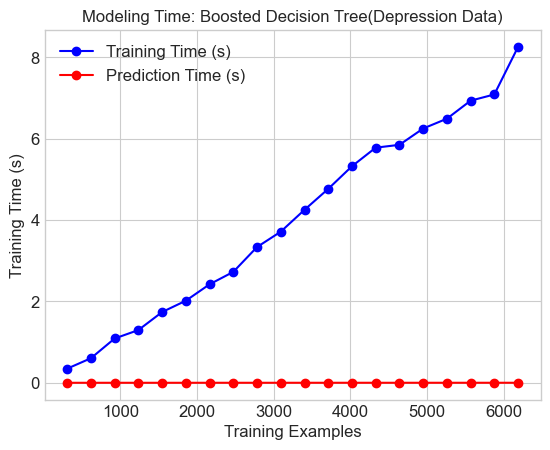

Model Evaluation Metrics Using Test Dataset
*****************************************************
Model Training Time (s):   2.77373
Model Prediction Time (s): 0.00161

F1 Score:  0.93
Accuracy:  0.93     AUC:       0.93
Precision: 0.98     Recall:    0.89
*****************************************************


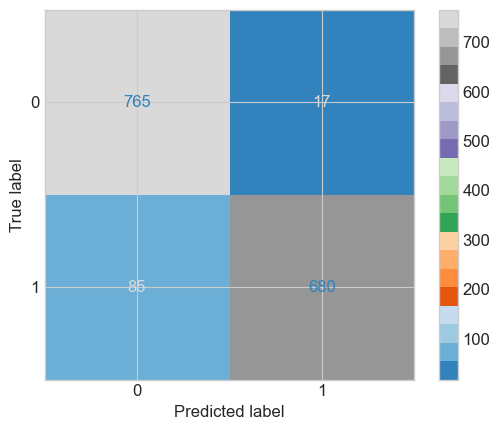

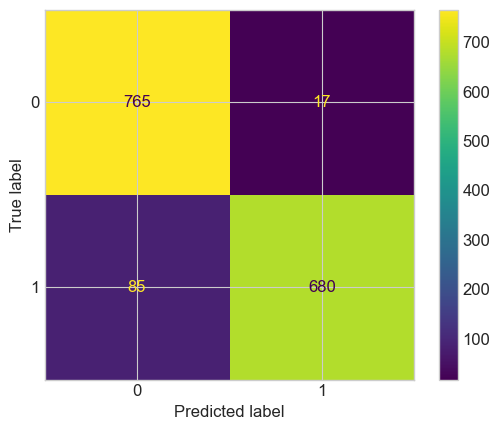

In [21]:
# Boosted Decision Tree
hyperBoost(X_train_tfidf, y_train, X_test_tfidf, y_test,title="Model Complexity Curve for Boosted Decision Tree \nHyperparameter : No. Estimators")
n_est, learn_rate = BoostedGridSearchCV(X_train_tfidf, y_train)
estimator = GradientBoostingClassifier(n_estimators=n_est, learning_rate=learn_rate, random_state=100)

train_samp, BT_fit_time, BT_pred_time = plot_learning_curve(estimator, X_train_tfidf, y_train,title="Boosted Decision Tree(Depression Data)")
final_classifier_evaluation(estimator, X_train_tfidf, X_test_tfidf, y_train, y_test)

## Model Comparison Plots

Finally, Comparing training times and F1 score for the 5 different algorithms on L1 treated dataset

In [22]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Decision Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Decision Tree")
    plt.legend(loc="best")
    plt.show()


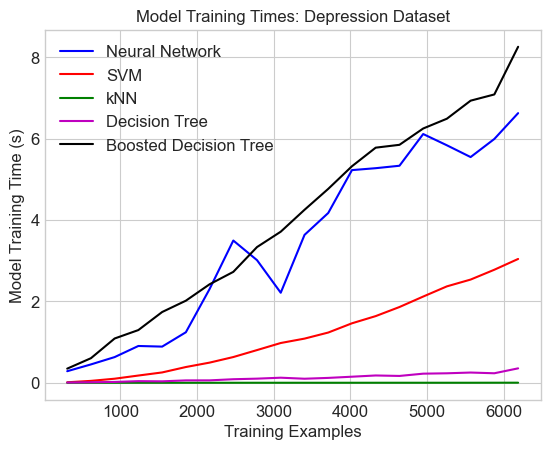

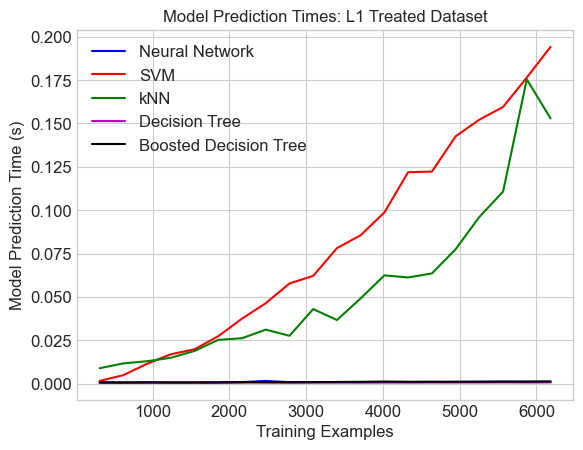

In [23]:
compare_fit_time(train_samp, NN_fit_time, SVM_fit_time, KNN_fit_time,
                 DT_fit_time, BT_fit_time, 'Depression Dataset')      
                         
compare_pred_time(train_samp, NN_pred_time, SVM_pred_time, KNN_pred_time,
                 DT_pred_time, BT_pred_time, 'L1 Treated Dataset')   